# Darth Vader or Hedgehog
with tflearn

In [1]:
import tflearn
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import tensorflow as tf
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization
from sklearn.model_selection import train_test_split
import time

In [2]:
# pal: -1 (RGBA); 0 (grayscale); 1 (RGB)
# fill: if True adds black borders before resize
def loadAndResize(imgPath, size=64, pal=1, fill=True):
    img = cv2.imread(imgPath, pal)
    if img is None:
        raise FileNotFoundError('File "{}" not found.'.format(imgPath))
    if fill:
        shape = np.shape(img)
        if shape[0] > shape[1]:
            bSize = int((shape[0] - shape[1])/2)
            img = cv2.copyMakeBorder(img,0,0,bSize,bSize,cv2.BORDER_CONSTANT,value=[0,0,0])
        else:
            bSize = int((shape[1] - shape[0])/2)
            img = cv2.copyMakeBorder(img,bSize,bSize,0,0,cv2.BORDER_CONSTANT,value=[0,0,0])
    if pal != 0:
        return cv2.cvtColor(cv2.resize(img, (size, size)), cv2.COLOR_BGR2RGB)
    else: 
        return cv2.resize(img, (size, size))

In [20]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#### Load data
Pictures of Darth Vader and hedgehogs found on the internet.  
Dataset created by pics2dataset.ipynb

In [3]:
imgSize = 227
pal = 3

# loading data
# 227 x 227 px RGB pictures
# 56 of Darth Vader [1, 0]
# 56 of hedgehogs [0, 1]
data = np.load('227x227_rgb_dv_hh.npy', encoding='bytes')

#y_data, x_data = data.transpose()
x_data = np.array([i[1] for i in data]).reshape(-1, imgSize, imgSize, pal)
y_data = [i[0] for i in data]

In [4]:
np.shape(data)

(112, 2)

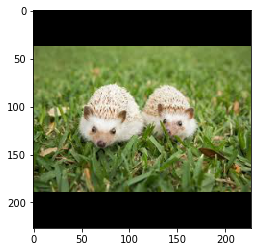

[0, 1]


In [5]:
i = 73
plt.imshow(x_data[i])
plt.show()
print (y_data[i])

In [31]:
# shuffle and split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [32]:
np.shape(x_test)

(23, 227, 227, 3)

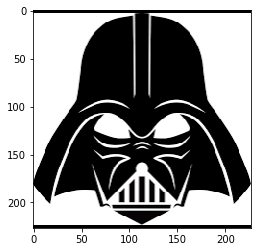

[1, 0]


In [35]:
i = 75
plt.imshow(x_train[i])
plt.show()
print (y_train[i])

#### AlexNet initialization
(https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

In [36]:
# reset
tf.reset_default_graph()

#tflearn.init_graph(num_cores=1, gpu_memory_fraction=0.1, soft_placement=False)

# Building 'AlexNet'
network = input_data(shape=[None, 227, 227, 3], name='input')
network = conv_2d(network, 96, 12, strides=4, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 256, 5, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 256, 3, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = fully_connected(network, 4096, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 4096, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 2, activation='softmax')
network = regression(network, optimizer='momentum',
                     loss='categorical_crossentropy', learning_rate=0.001, name='targets')

# Training
model = tflearn.DNN(network, checkpoint_path='model_alexnet',
                    max_checkpoints=1, tensorboard_verbose=0)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [37]:
start = time.time()
model.fit({'input': x_train}, {'targets': y_train}, n_epoch=100, validation_set=({'input': x_test}, {'targets': y_test}), 
          show_metric=True, snapshot_step=20, snapshot_epoch=False, run_id='dv_hh')
print ("Total training time: {} s".format(time.time() - start))

Training Step: 199  | total loss: 0.90806 | time: 13.603s
| Momentum | epoch: 100 | loss: 0.90806 - acc: 0.8140 -- iter: 64/89
Training Step: 200  | total loss: 0.82429 | time: 19.301s
| Momentum | epoch: 100 | loss: 0.82429 - acc: 0.8310 | val_loss: 0.02795 - val_acc: 1.0000 -- iter: 89/89
--
Total training time: 1336.643168926239 s


In [48]:
model.save('dv_hh_alexnet_100epo.tfl')

In [ ]:
model.load('dv_hh_alexnet.tfl')

In [39]:
# img - path to image
def pred(img, fill=True):
    testImg = loadAndResize(img, size=227, pal=1, fill=fill)
    plt.imshow(testImg)
    plt.show()
    ans = model.predict(testImg.reshape(-1,227,227,3))
    print ('Darth Vader: {:.1f}%\n   Hedgehog: {:.1f}%'.format(100*ans[0][0], 100*ans[0][1]))

### Using trained network

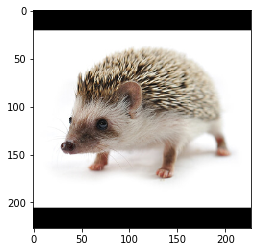

Darth Vader: 0.4%
   Hedgehog: 99.6%


In [40]:
pred('test/test1.jpg')

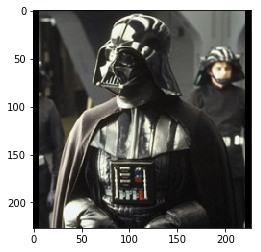

Darth Vader: 89.1%
   Hedgehog: 10.9%


In [41]:
pred('test/test2.jpg')

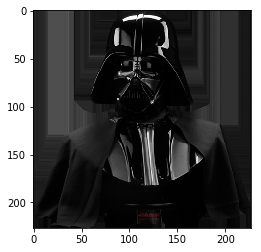

Darth Vader: 99.7%
   Hedgehog: 0.3%


In [42]:
pred('test/test3.jpg')

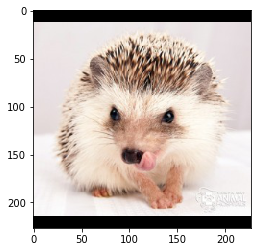

Darth Vader: 0.2%
   Hedgehog: 99.8%


In [43]:
pred('test/test4.jpg')

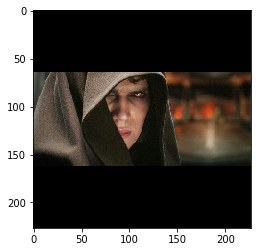

Darth Vader: 7.5%
   Hedgehog: 92.5%


In [44]:
pred('test/test5.jpg')

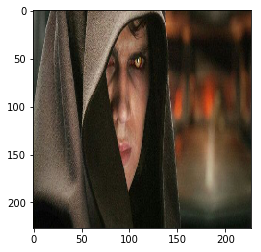

Darth Vader: 4.4%
   Hedgehog: 95.6%


In [45]:
pred('test/test5.jpg', fill=False)

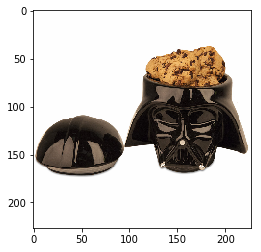

Darth Vader: 72.9%
   Hedgehog: 27.1%


In [46]:
pred('test/test6.jpg')

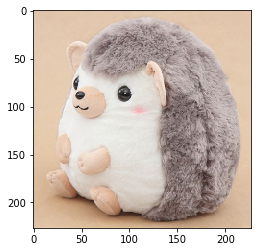

Darth Vader: 0.2%
   Hedgehog: 99.8%


In [47]:
pred('test/test7.jpg')